# Filtered ICA on Peak Patch Fields

In [1]:
%load_ext autoreload

In [1]:
import importlib as il
import copy

from pathlib import Path # For path manipulations and module loading
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 12})
import pickle

from scipy.signal import windows, get_window
from scipy.signal.windows import general_hamming as hamming

# Independent Component Analysis
# sklearn module contains contains a FastICA capability. We can chose the cost function (measure of non-Gaussianity): 
# cube for kurtosis and logcosh for negentropy approximation.
from sklearn.decomposition import FastICA

%autoreload 2
import sim_params
sim_params = il.reload(sim_params)
import init_fields
init_fields = il.reload(init_fields)
import slicer_fields
from slicer_fields import Slicer1D
slicer_fields = il.reload(slicer_fields)

import modules.gaussianfield as gf

UsageError: Line magic function `%autoreload` not found.


zeta multiplication factor = { (2*\pi*sidelength)/(sidelength_in_mpc) }^3

peak-patch/tools/powerspectrum_create

pkp tables/planck18_intermittent.dat
(1st column -- k; 2nd -- delta_delta power spectrum; 3rd -- zeta transfer func/k^2)
zeta power spectrum = 2nd col / 3rd^2

tables/plot_spectra.py line 142

zeta = zeta(g)

take flat GRF power spectrum, multiply by sqrt[ (2*\pi*N / N_in_Mpc)^3 {power spectra above} ].

will have real-space zeta(x) = zeta_g + fnl*chi^2

In [2]:
# d_filename='Fvec_fNL_17Mpc_n1024_nb64_nt1'
# dg_filename='Fvec_17Mpc_n1024_nb64_nt1'
# z_filename='zetang_17Mpc_n1024_nb64_nt1'
# zg_filename='zetag_17Mpc_n1024_nb64_nt1'
# filenames=[d_filename,dg_filename,z_filename, zg_filename]

## Import 1D field slices from PkP

In [3]:
path_realization = 'peak-patch-runs/n1024bigR/z2/fnl1e6/'
seed = 30

slicer = Slicer1D(seed, path_realization)

NameError: name 'Slicer1D' is not defined

In [16]:
crnt_seed = np.random.get_state()
np.random.set_state(crnt_seed)

(707, 245, range(0, 896))


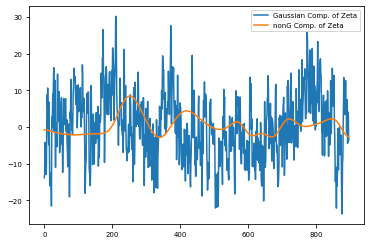

In [17]:
slicer.set_seed(crnt_seed)

factor = int(1e10)

fields = slicer.slice_1d(False)
d_1d, dg_1d, dng_1d, z_1d, zg_1d, zng_1d = fields
size = slicer.side_length
idx = slicer.indices

print(idx)
z_1d = factor * z_1d
zg_1d = factor * zg_1d
zng_1d = factor * zng_1d

with open(f'np_random_states/state_x{idx[0]}_y{idx[1]}.pickle', 'wb') as f:
    pickle.dump(crnt_seed, f)

# with open('crnt_seed.pickle', 'rb') as f:
#     crnt_seed = pickle.load(f)

#--------------------------------------------------#

### Plot 1D Zeta fields

# plt.plot(d_1d, label='Total Zeta')
plt.plot(dg_1d, label='Gaussian Comp. of Zeta')
plt.plot(dng_1d, label='nonG Comp. of Zeta')

plt.legend()

## <u>Apply Filtered ICA to 1D strips from the 3D fields</u>
<b> For fully determined ICA separation.
<br>
Sklearn's implementation does not allow for underdetermined separation. </b>

### Setup

In [18]:
# Top hat bands
def window(g, N, k_low, k_up):
    """
    
    """
    
    x = np.fft.rfft(g)
    # print(x[0:10])

    k = np.fft.rfftfreq(N) * N
    # print(k[0:10])

    # print(k[:N//2])

    k_low = np.ones(np.shape(x))*k_low
    k_up = np.ones(np.shape(x))*k_up

    x = np.where(np.logical_and(np.less_equal(k, k_up), np.greater(k, k_low)), x, 0)
    x_inv = np.fft.irfft(x)

    return x_inv

def window_hamm(g, N, k_low, k_high):
    """Apply Hamming window filter in k-space.
    
    """

    x = np.fft.rfft(g)

    k = np.fft.rfftfreq(N) * N

    k_range = k_high - k_low
    hamm = np.zeros(np.shape(x))
    hamm[k_low:k_high] = hamming(k_range, 0.5)

    k_low = np.ones(np.shape(x))*k_low
    k_high = np.ones(np.shape(x))*k_high

    x = np.where(np.logical_and(np.less_equal(k, k_high), np.greater_equal(k, k_low)), x*hamm, 0)
    x_inv = np.fft.irfft(x)
    
    return x_inv, hamm

def filter(g_field, ng_field, size, k_low, k_high):
    """
    
    """

    g_field = window(g_field, size, k_low, k_high)
    ng_field = window(ng_field, size, k_low, k_high)

    return [g_field, ng_field]


In [27]:
def ica_setup(source_noise, source_nonG):
    """
    source_noise    :   grf generated using gaussianfield [in Notebook Setup above]
    source_nonG     :   returns n columns corresponding to n gaussian peaks that are shifted by xPeak/xc relative to 0 (and scaled by the size of the field)

    source_comps    :   array of source component arrays
    num_comps       :   num of different source signals/components, i.e. GRF & no. of peaks
    num_samples     :   num of observations (has to be >= num_comps)
    mix_matrix      :   mixing matrix generated randomly with entries over [0.5, 1)
    mix_signal      :   resulting mixed/observed signals (not prewhitened)
    """

    # source_noise = zg_1d # Gaussian random noise
    # source_nonG = zng_1d

    source_comps = np.vstack([source_nonG, source_noise]) 
    num_comps = source_comps.shape[0]
    num_samples = num_comps

    mix_matrix = (1+np.random.random((num_samples, num_comps)))/2.0 
    mix_signal = np.dot(mix_matrix, source_comps) # mixed signals

    return mix_signal, source_comps, num_comps

def ica_run(mix, num_comps, max_iter=1e4, tol=1e-15, 
        fun='logcosh', algo='parallel', white='unit-variance'):
    """Initialize FastICA with given params.

    Notes:
            Logcosh is negentropy.
    """
    
    transformer = FastICA(n_components=num_comps, algorithm=algo, whiten=white, max_iter=max_iter, tol=tol, fun=fun)

    # run FastICA on observed (mixed) signals
    sources = transformer.fit_transform(mix.T) # run FastICA on observed signals

    return sources.T

def ica_swap(source_comps, ica_src):
    """
    
    """
    
    # print('\nBeginning swap...')
    ica_sources = np.ndarray.copy(ica_src)

    srcng = source_comps[0, :]
    srcg = source_comps[1, :]
    ica0 = ica_sources[0, :]
    ica1 = ica_sources[1, :]

    dist_ng0 = np.linalg.norm(srcng**3 - ica0**3, 1)
    dist_ng1 = np.linalg.norm(srcng**3 - ica1**3, 1)
    dist_g0 = np.linalg.norm(srcg**3 - ica0**3, 1)
    dist_g1 = np.linalg.norm(srcg**3 - ica1**3, 1)
    print('dist nong->ica1:', dist_ng1, ' | dist nong->ica0:', dist_ng0)
    print('dist g->ica0:', dist_g0, ' | dist g->ica1:', dist_g1)
    if dist_ng0 > dist_ng1:
        print('dist nong->ica1:', dist_ng1, ' | dist nong->ica0:', dist_ng0)
        print('dist g->ica0:', dist_g0, ' | dist g->ica1:', dist_g1)
        ica_sources = np.flip(ica_sources, 0)
        print('Swapped!')

    icang, icag = ica_sources[0, :], ica_sources[1, :]

    # print('...ending swap.\n')
    return ica_sources

def ica_signflip(source_comps, ica_src):
    """
    
    """
    
    # print('\nBeginning flip...')
    ica_sources = np.ndarray.copy(ica_src)

    srcng = source_comps[0, :]
    srcg = source_comps[1, :]
    icang = ica_sources[0, :]
    icag = ica_sources[1, :]

    dist_gg = np.linalg.norm(srcg - icag, 1)
    dist_neg_gg = np.linalg.norm(srcg + icag, 1)
    dist_ngng = np.linalg.norm(srcng - icang, 1)
    dist_neg_ngng = np.linalg.norm(srcng + icang, 1)
    
    if dist_gg > dist_neg_gg:
        # print('dist_gg:', dist_gg, ' | dist_neg_gg:', dist_neg_gg)
        icag = -icag
        print('Gauss sign flipped!')

    if dist_ngng > dist_neg_ngng:
        # print('dist_ngng:', dist_ngng, ' | dist_neg_ngng:', dist_neg_ngng)
        icang = -icang
        print('NonG sign flipped!')

    ica_sources[0, :], ica_sources[1, :] = icang, icag
    
    # print('...ending flip.\n')
    return ica_sources

def ica_scale(source_comps, ica_src):
    """
    
    """

    ica_sources = np.ndarray.copy(ica_src)

    src_ng_max = np.abs(source_comps[0]).max()
    src_g_max = np.abs(source_comps[1]).max()
    src_max = np.abs(source_comps).max()
    ica_ng_max = np.abs(ica_sources[0]).max()
    ica_g_max = np.abs(ica_sources[1]).max()
    ica_max = np.abs(ica_sources).max()
    
    ng = ica_sources[0, :]
    ng = ng * ( src_ng_max / ica_ng_max )
    g = ica_sources[1, :]
    g = g * ( src_g_max / ica_g_max )
    ica_sources[0, :] = ng; ica_sources[1, :] = g

    ica_ng_max = np.abs(ng).max()
    ica_g_max = np.abs(g).max()
    ica_max = np.abs(ica_sources).max()

    return ica_sources, [src_max, src_ng_max, src_g_max], [ica_max, ica_ng_max, ica_g_max]

def ica_prepres(source_comps, ica_src):
    """
    
    """

    ica_sources = np.ndarray.copy(ica_src)

    ica_sources = ica_swap(source_comps, ica_sources)
    ica_sources = ica_signflip(source_comps, ica_sources)
    ica_sources, src_max, ica_max = ica_scale(source_comps, ica_sources)

    return ica_sources, src_max, ica_max

dist nong->ica1: 50.837538913537095  | dist nong->ica0: 50.78407015304029
dist g->ica0: 180.57022287150278  | dist g->ica1: 180.62605662006962
Gauss sign flipped!


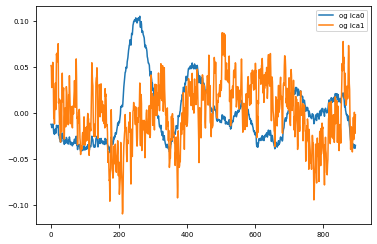

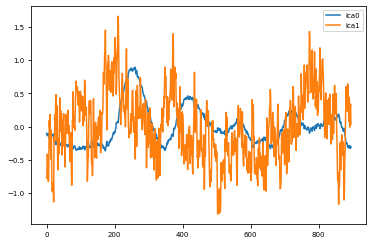

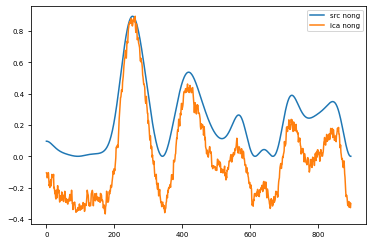

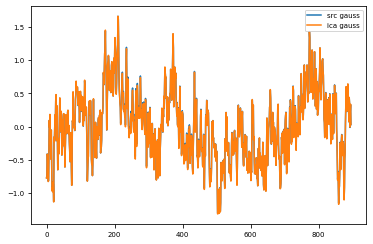

In [36]:
#
#
# ICA parameters/vars
#
#
max_iter = int(9e13)
tol = 1e-12

#
#
# Run ICA
#
#
mix_signal, source_comps, num_comps = ica_setup(zg_1d, zng_1d)
ica_src_og = ica_run(mix_signal, num_comps, max_iter, tol)

# #--------------------------------------------------#

# ica_srcs = ica_swap(source_comps, ica_src_og)
# ica_srcf = ica_signflip(source_comps, ica_srcs)
# ica_src, src_max, ica_max = ica_scale(source_comps, ica_srcf)
ica_src, src_max, ica_max = ica_prepres(source_comps, ica_src_og)

plt.plot(ica_src_og[0, :], label='og ica0'); plt.plot(ica_src_og[1, :], label='og ica1'); plt.legend(); plt.show()
plt.plot(ica_src[0, :], label='ica0'); plt.plot(ica_src[1, :], label='ica1'); plt.legend(); plt.show()
plt.plot(source_comps[0, :], label='src nong'); plt.plot(ica_src[0, :], label='ica nong'); plt.legend(); plt.show()
plt.plot(source_comps[1, :], label='src gauss'); plt.plot(ica_src[1, :], label='ica gauss'); plt.legend(); plt.show()

### Apply Sklearn's $\texttt{FastICA}$

In [32]:
from math import log10, floor
round_to_n = lambda x, n: round(x, -int(floor(log10(x))) + (n - 1))

dist nong->ica1: 50.82386069846561  | dist nong->ica0: 50.784070152797355
dist g->ica0: 180.57022287066098  | dist g->ica1: 180.5206386917696

Processing k-bin number:    1 ...
dist nong->ica1: 4.897262508897242  | dist nong->ica0: 4.8237829077539605
dist g->ica0: 31.125609128727568  | dist g->ica1: 31.147894165735288

Processing k-bin number:    2 ...
dist nong->ica1: 4.603789849690805  | dist nong->ica0: 4.669128990476273
dist g->ica0: 6.60415630900596  | dist g->ica1: 6.668673789811264
dist nong->ica1: 4.603789849690805  | dist nong->ica0: 4.669128990476273
dist g->ica0: 6.60415630900596  | dist g->ica1: 6.668673789811264
Swapped!

Processing k-bin number:    3 ...
dist nong->ica1: 0.09365013327192864  | dist nong->ica0: 0.09547752013473063
dist g->ica0: 5.225025426253348  | dist g->ica1: 5.167957741501754
dist nong->ica1: 0.09365013327192864  | dist nong->ica0: 0.09547752013473063
dist g->ica0: 5.225025426253348  | dist g->ica1: 5.167957741501754
Swapped!
Gauss sign flipped!
NonG s

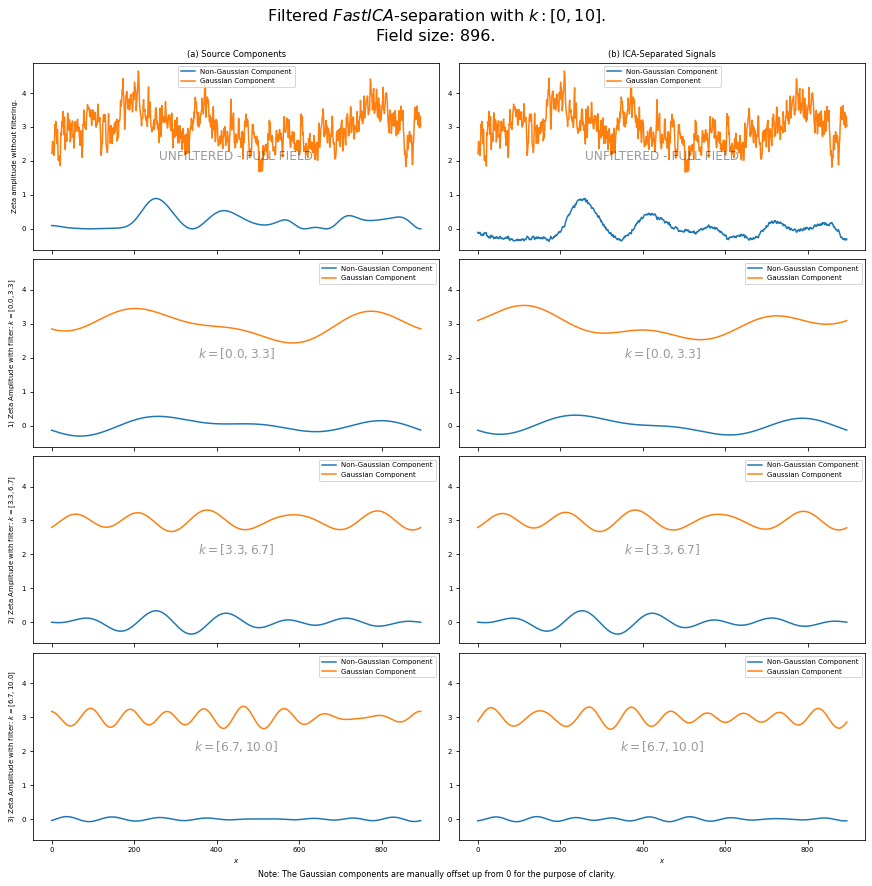

In [37]:
"""Filtering.

"""

#
#
# Filtering parameters/vars
#
#
nbins = 3
k_size = size//2 + 1
k_low = 0
k_high = 10
kc = np.linspace(0, k_high, nbins+1)
# kc = np.array([0, 20, 40, 80])
kc_size = kc.size

#
#
# ICA parameters/vars
#
#
max_iter = int(9e13)
tol = 1e-12
ica_src = np.zeros((kc_size+1, 2, size))

#
#
# Run ICA
#
#
mix_signal, src, num_comps = ica_setup(zg_1d, zng_1d)
ica_src_og = ica_run(mix_signal, num_comps, max_iter, tol)
ica_src[0, :], src_max, ica_max = ica_prepres(src, ica_src_og)


#
#
# Plot
#
#
plt.rcParams.update({'font.size': 7})
nrows = nbins + 1
ncols = 2

fig, ax = plt.subplots(nrows, ncols, sharex='all', figsize=(6*ncols, 3*nrows), constrained_layout=True)

offset = src_max[0]*1.8
offset_ica = ica_max[0]*1.8

ax00 = ax[0, 0]
# Plotting source components
ax[0, 0].set_title("(a) Source Components")
for j in range(num_comps):
    if j == 0:
        label = "Non-Gaussian Component"
    else:
        label = "Gaussian Component"
    ax[0, 0].plot(src[j, :] + offset*j, label=label)
ax[0, 0].set(ylabel="Zeta amplitude without filtering.")
ax[0, 0].legend()

ax01 = ax[0, 1]
# Plotting ICA-separated signals
ax[0, 1].set_title("(b) ICA-Separated Signals")
ax[0, 1].sharey(ax00)
for j in range(num_comps):
    if j == 0:
        label = "Non-Gaussian Component"
    else:
        label = "Gaussian Component"
    ax[0, 1].plot(ica_src[0, j, :] + offset_ica*j, label=label) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
ax[0, 1].legend()

ax[0, 0].text(0.5, 0.5, "UNFILTERED - FULL FIELD", 
                fontsize='xx-large', transform=ax[0, 0].transAxes, 
                    ha='center', va='center', alpha=0.4)
ax[0, 1].text(0.5, 0.5, "UNFILTERED - FULL FIELD", 
                fontsize='xx-large', transform=ax[0, 1].transAxes, 
                    ha='center', va='center', alpha=0.4)


for i in range(kc_size-1):
    count = i+1
    klow = kc[i]
    khigh = kc[i+1]

    print(f"\nProcessing k-bin number:    {count} ...")

    #
    #
    # Filter
    #
    #
    filtered = filter(zg_1d, zng_1d, size, int(klow), int(khigh))
    zgf, zngf = filtered[0], filtered[1]
    
    #
    #
    # Run ICA
    #
    #
    mix_signal, src, num_comps = ica_setup(zgf, zngf)
    ica_src_og = ica_run(mix_signal, num_comps, max_iter, tol)
    ica_src[count, :], src_max, ica_max = ica_prepres(src, ica_src_og)

    offset_ = src_max[0]*1.8
    offset_ica_ = ica_max[0]*1.8
    klow = round(klow, 1); khigh = round(khigh, 1)

    # Plotting source components
    ax[count, 0].sharey(ax00)
    for j in range(num_comps):
        if j == 0:
            label = "Non-Gaussian Component"
        else:
            label = "Gaussian Component"
        ax[count, 0].plot(src[j, :] + offset*j, label=label)
    ax[count, 0].set(ylabel=f'{i+1}) ' + "Zeta Amplitude with filter: " + r"$k=[{{{kl}}}, {{{kh}}}]$".format(kl=klow, kh=khigh))
    ax[count, 0].legend()
    
    ax[count, 1].sharey(ax00)
    # Plotting ICA-separated signals
    for j in range(num_comps):
        if j == 0:
            label = "Non-Gaussian Component"
        else:
            label = "Gaussian Component"
        ax[count, 1].plot(ica_src[count, j, :] + offset_ica*j, label=label) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
    ax[count, 1].legend()

    ax[count, 0].text(0.5, 0.5, r"$k=[{{{kl}}}, {{{kh}}}]$".format(kl=klow, kh=khigh), 
                            fontsize='xx-large', transform=ax[count, 0].transAxes, 
                                ha='center', va='center', alpha=0.4)
    ax[count, 1].text(0.5, 0.5, r"$k=[{{{kl}}}, {{{kh}}}]$".format(kl=klow, kh=khigh), 
                            fontsize='xx-large', transform=ax[count, 1].transAxes, 
                                ha='center', va='center', alpha=0.4)

ax_count = kc_size-1
ax[ax_count, 0].set(xlabel=r'$x$')
ax[ax_count, 1].set(xlabel=r'$x$')

fig.suptitle(rf'Filtered $\it{{FastICA}}$-separation with $k: [{{{k_low}}}, {{{k_high}}}]$.' + f'\nField size: {size}.', fontsize=16)

note="Note: The Gaussian components are manually offset up from 0 for the purpose of clarity."
fig.text(0.5, -0.01, note, wrap=True, horizontalalignment='center', fontsize=8)
plt.show()

plt.savefig(f'/fs/lustre/cita/haider/projects/primordialNonG_code/ica/plots/icafiltered_pkp_s{size}_{klow}to{khigh}k{nbins}.png')

<Figure size 432x288 with 0 Axes>

### TODO: Rank-order the extracted signals (by a nonG measure)
e.g. using kurtosis

In [13]:
# # Rank-order by a nonGaussianity measure (kurtosis for simplicity)
# nt = 100; a = np.empty((nt,s.shape[0],s.shape[1])) 
# for i in range(nt):
#     a[i] = ica.extract_peaks_nn(num_samples=num_samples, num_components=num_comps, noise=noise, aPeak=aPeak, xPeak=xPeak, wPeak=wPeak, ns=size_field)[-1]
# kur = ica.kurtosis(a)

# print(kur.shape)
# fig, a = plt.subplots()
# fig.set_size_inches(15, 15)
# for i in range(kur.shape[-1]):
#     a.plot(kur[:,i]+25.*i)